In [3]:
import wfdb
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
import pandas as pd
from scipy.signal import butter, filtfilt

In [4]:
#limpiar carpeta de archivos
def limpiar_carpeta(carpeta):
    for file in os.listdir(carpeta):
        os.remove(carpeta+'/'+file)

In [5]:
#algoritmo pan tompkins
# Paso 1: Derivada
def derivada_ecg(ecg_signal):
    return np.diff(ecg_signal)

# Paso 2: Señal cuadrada
def cuadrado_ecg(derivada_signal):
    return np.square(derivada_signal)

# Paso 3: Filtro de integración móvil
def filtro_integracion(ecg_signal, window_size=15):
    window = np.ones(window_size) / window_size
    return np.convolve(ecg_signal, window, mode='same')

# Paso 4: Detección de picos
def detectar_picos(ecg_signal, threshold=0.6):
    # Normalizamos la señal
    ecg_signal_normalizada = ecg_signal / np.max(ecg_signal)
    # Detectar los picos que superan el umbral
    picos = np.where(ecg_signal_normalizada > threshold)[0]
    return picos

# Función principal del algoritmo Pan-Tompkins
def pan_tompkins(ecg_signal):
    # Derivar la señal
    ecg_derivada = derivada_ecg(ecg_signal)
    
    # Cuadrar la señal derivada
    ecg_cuadrada = cuadrado_ecg(ecg_derivada)
    
    # Filtrar la señal con integración
    ecg_filtrada = filtro_integracion(ecg_cuadrada)
    
    # Detectar picos
    picos_r = detectar_picos(ecg_filtrada)
    
    return picos_r

In [6]:
# Función que busca todos los nombres únicos de archivos en un directorio sin su extrensión
def get_files(path,type):
    files = []
    for file in os.listdir(path):
        if file.endswith(type):
            files.append(file[:-4])
    return files
def read_file_hea(filename):
    # lee archivo .hea
    record = wfdb.rdheader('data/training/'+filename)
    return record
def read_file_mat(file, path):
    # carga archivo .mat (tiene las señales)
    mat_data = loadmat(path + file +'.mat')
    # claves del archivo .mat para saber como se llaman las señales
    #print(signals.keys())
    signals = mat_data['val']
    # recorta y deja sólo los últimos 10 segundos de señal
    return signals, file

def grafica_ecg(record, signals, file, type, picos_r=None):
    #grafica las señales ecg
    plt.figure(figsize=(12, 6))
    for i in range(len(record.sig_name)):
        plt.subplot(len(record.sig_name), 1, i+1)
        plt.plot(signals[i, :], label=f'Señal: {record.sig_name[i]}')
        if picos_r is not None:
            plt.plot(picos_r, signals[i, picos_r], 'ro', markersize=1)
            #Imprime los picos_r
            print(f'Picos R señal {record.sig_name[i]}: {picos_r}')

        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    # genera jpg
    
    plt.close()


def ecg_filtring_and_peaks(data, signalName, cutoff=1, fs=250, order=2):
    ecg_signals = ['I', 'II', 'III', 'V']
    #Se filtra solo si es una señal de ECG
    picos_r = []
    if signalName in ecg_signals:
        #detecta picos R
        picos_r = pan_tompkins(data)
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y, picos_r
    else:
        return data, picos_r



In [13]:
# limpiar señales

def clean_signals_and_r_peak(files, path):
    for fileName in files:
        print('Limpiando señales de: ', fileName)
        record = read_file_hea(fileName)
        signals, file = read_file_mat(fileName, path)
        # recorta y deja sólo los últimos 10 segundos de señal
        signals = signals[:, -record.fs*10:]
        
        # guarda las señales sucias en un archivo .mat y .hea
        sio.savemat('data/dirty/'+file+'.mat', {'val': signals})

        #aplica filtro de paso bajo solo a señales de ECG
        ecg_filtring= [ecg_filtring_and_peaks(signals[i, :], record.sig_name[i]) for i in range(signals.shape[0])]
        print('ecg_filtring:  ',ecg_filtring)
        #solo la señal, sin los picos r
        filtered_signal = np.array(ecg_filtring[0][0])
        
        baseline_corrected_signal = signals - filtered_signal
        

        picos_r = ecg_filtring[0][1]
        print('picos_r: ',picos_r)

        
        # guarda las señales limpias en un archivo .mat y .hea con los picos R
        sio.savemat('data/cleaned/'+file+'.mat', {'val': baseline_corrected_signal, 'picos_r': picos_r})
        #sio.savemat('data/cleaned/'+file+'.mat', {'val': baseline_corrected_signal})

#graficar señales y otorgar picos r
def graf_signals(files, path, type, cant):
    for fileName in files[:cant]:
        print('Graficando señales de: ', fileName)
        record = read_file_hea(fileName)
        signals, file = read_file_mat(fileName, path) 
        picos_r = sio.loadmat(path +file+'.mat')['picos_r']
        grafica_ecg(record,signals,file,type,picos_r)
        
        
def watch_two_signals(file1,file2, path1,path2):
    record1 = read_file_hea(file1)
    signals1, file1 = read_file_mat(file1, path1)
    record2 = read_file_hea(file2)
    signals2, file2 = read_file_mat(file2, path2)
    plt.figure(figsize=(12, 6))
    for i in range(len(record1.sig_name)):
        plt.subplot(len(record1.sig_name), 1, i+1)
        plt.plot(signals1[i, :], label=f'Señal final: {record1.sig_name[i]}')
        #tamaño de los puntos
        plt.plot(signals2[i, :], label=f'Señal inicial: {record2.sig_name[i]}')
        plt.xlabel('Muestras')
        plt.ylabel(record1.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record1.comments[0] + ' - ' + record1.comments[1])
    # genera jpg
    plt.show()
    plt.close()

In [84]:
# Limpiar carpeta de archivos
limpiar_carpeta('data/imgs/clean')
limpiar_carpeta('data/imgs/dirty')

In [11]:
# mostrar datos de los .hea
files = get_files('data/training','.hea')
record = read_file_hea(files[0])
print(record.__dict__)

#sig_name son las señales

#define los tipos de señales que existen
#clasificar tipos de arritmias
signal_types = []
for file in files:
    record = read_file_hea(file)
    # si encuentra un nuevo comentario lo agrega a la lista
    for signalName in record.sig_name:
        if signalName not in signal_types:
            signal_types.append(signalName)

print(signal_types)

{'record_name': 'a103l', 'n_sig': 3, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 82500, 'base_time': None, 'base_date': None, 'comments': ['Asystole', 'False alarm'], 'sig_name': ['II', 'V', 'PLETH'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['a103l.mat', 'a103l.mat', 'a103l.mat'], 'fmt': ['16', '16', '16'], 'samps_per_frame': [1, 1, 1], 'skew': [None, None, None], 'byte_offset': [24, 24, 24], 'adc_gain': [7247.0, 10520.0, 12530.0], 'baseline': [0, 0, 0], 'units': ['mV', 'mV', 'NU'], 'adc_res': [16, 16, 16], 'adc_zero': [0, 0, 0], 'init_value': [-171, 9127, 6042], 'checksum': [-27403, -301, -17391], 'block_size': [0, 0, 0]}
['II', 'V', 'PLETH', 'aVF', 'ABP', 'RESP', 'III', 'MCL', 'I', 'aVR', 'aVL']


# Ejecución

In [14]:
#limpia y guarda picos_r en una copia, y en otra deja la señal sucia
path='data/training/'
files = get_files(path, '.mat')
clean_signals_and_r_peak(files, path)



Limpiando señales de:  a103l
ecg_filtring:   [(array([-108.772432  , -111.74779694, -114.6858942 , ..., -229.9034937 ,
       -229.96134901, -230.01012562]), array([ 298,  533,  534,  535,  536,  547,  553,  554,  555,  556,  890,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102,
       2103, 2104, 2215, 2216])), (array([8046.87253356, 8056.48311603, 8066.08780232, ..., 8396.33147303,
       8396.17289696, 8396.04202975]), array([  64,   65,   66,   67,   68,   72,   77,  184,  185,  202,  250,
        298,  548,  550,  552,  553,  554,  555,  557,  703,  704,  705,
        706,  763,  764,  765, 1000, 1001, 1106, 1107, 1108, 1109, 1110,
       1111, 1112, 1113, 1114, 1116, 1117, 1118, 1132, 1151, 1152, 1153,
       1154, 1155, 1156, 1157, 1158, 1159, 1191, 1192, 1193, 1194, 1197,
       1198, 1199, 1366, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390,
       1391, 1392, 1720, 1721, 1832, 1952, 1970, 1971, 1972, 1973, 1974,
       1978, 1979, 1980, 1981, 2173, 21

C:\Users\valen\AppData\Local\Temp\ipykernel_23480\2737537373.py:18: RuntimeWarning: invalid value encountered in divide
  ecg_signal_normalizada = ecg_signal / np.max(ecg_signal)


ecg_filtring:   [(array([-363.23461329, -361.64775023, -360.05057219, ..., -345.45758941,
       -345.41663006, -345.38195641]), array([  33,  125,  126,  137,  138,  175,  176,  177,  178,  179,  180,
        181,  182,  183,  184,  185,  186,  187,  188,  189,  198,  199,
        200,  201,  202,  204,  205,  206,  207,  301,  303,  304,  305,
        306,  307,  309,  311,  312,  313,  314,  330,  333,  334,  335,
        336,  337,  340,  365,  368,  432,  433,  434,  436,  437,  516,
        533,  534,  535,  536,  537,  538,  539,  540,  541,  542,  543,
        544,  545,  626,  627,  628,  629,  630,  703,  704,  705,  706,
        707,  708,  829,  831,  832,  833,  834,  835,  836,  837,  838,
        839,  840, 1014, 1016, 1019, 1077, 1078, 1079, 1080, 1081, 1083,
       1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1375, 1376, 1377,
       1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1428,
       1429, 1430, 1431, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1

['Asystole', 'Bradycardia', 'Ventricular_Flutter_Fib', 'Tachycardia', 'Ventricular_Tachycardia']
Graficando señales de:  b124s
Picos R señal II: [[ 349  350  351  352  353  354  355  356  357  358  359  360  361  362
   380  797  798  799  800 1201 1202 1203 1237 1238 1239]]
Picos R señal V: [[ 349  350  351  352  353  354  355  356  357  358  359  360  361  362
   380  797  798  799  800 1201 1202 1203 1237 1238 1239]]
Picos R señal PLETH: [[ 349  350  351  352  353  354  355  356  357  358  359  360  361  362
   380  797  798  799  800 1201 1202 1203 1237 1238 1239]]


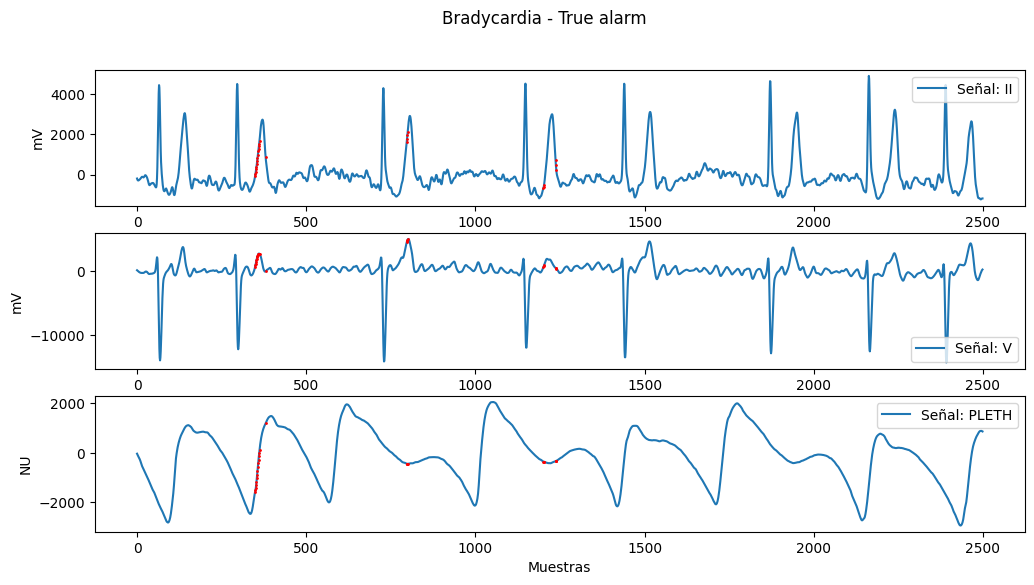

Graficando señales de:  b125l
Picos R señal II: [[ 131  172  353  360  361  362  363  364  365  366  371  516  517  518
   519  520  521  522  523  524  525  560  861  903  904  905  906  907
   908  909  910 1120 1121 1122 1123 1124 1125 1140 1141 1142 1143 1144
  1145 1146 1396 1397 1635 1636 1637 1638 1639 1670 1671 1672 1673 1674
  1675 1676 1677 1941 1942 2233 2234 2235 2261 2444 2445 2446 2447 2448
  2449 2450 2451 2452 2453 2454]]
Picos R señal V: [[ 131  172  353  360  361  362  363  364  365  366  371  516  517  518
   519  520  521  522  523  524  525  560  861  903  904  905  906  907
   908  909  910 1120 1121 1122 1123 1124 1125 1140 1141 1142 1143 1144
  1145 1146 1396 1397 1635 1636 1637 1638 1639 1670 1671 1672 1673 1674
  1675 1676 1677 1941 1942 2233 2234 2235 2261 2444 2445 2446 2447 2448
  2449 2450 2451 2452 2453 2454]]
Picos R señal PLETH: [[ 131  172  353  360  361  362  363  364  365  366  371  516  517  518
   519  520  521  522  523  524  525  560  861  903  9

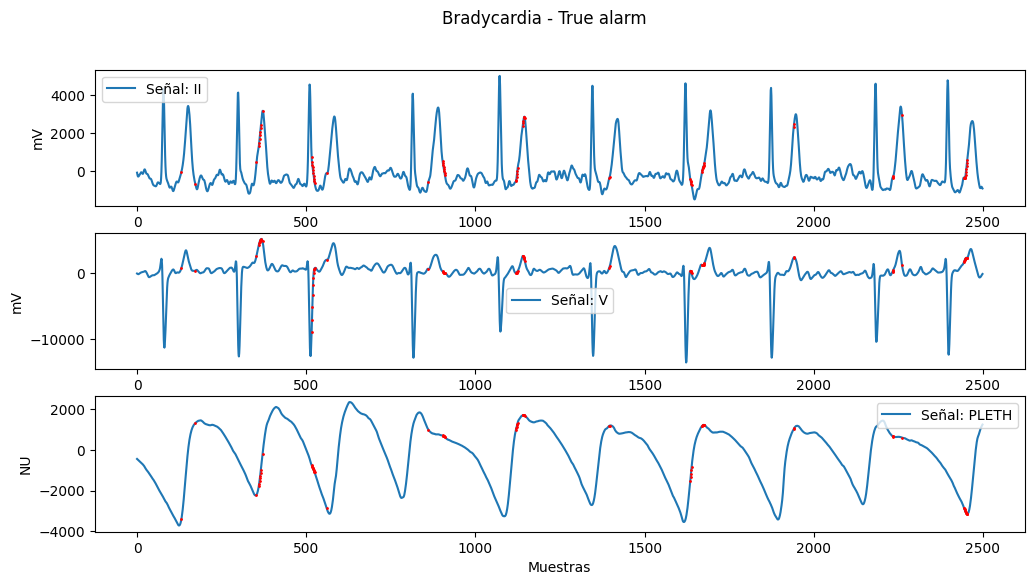

Graficando señales de:  b126s
Picos R señal II: [[908 909 910 911 912 913 914 915 916 917 918]]
Picos R señal V: [[908 909 910 911 912 913 914 915 916 917 918]]
Picos R señal PLETH: [[908 909 910 911 912 913 914 915 916 917 918]]


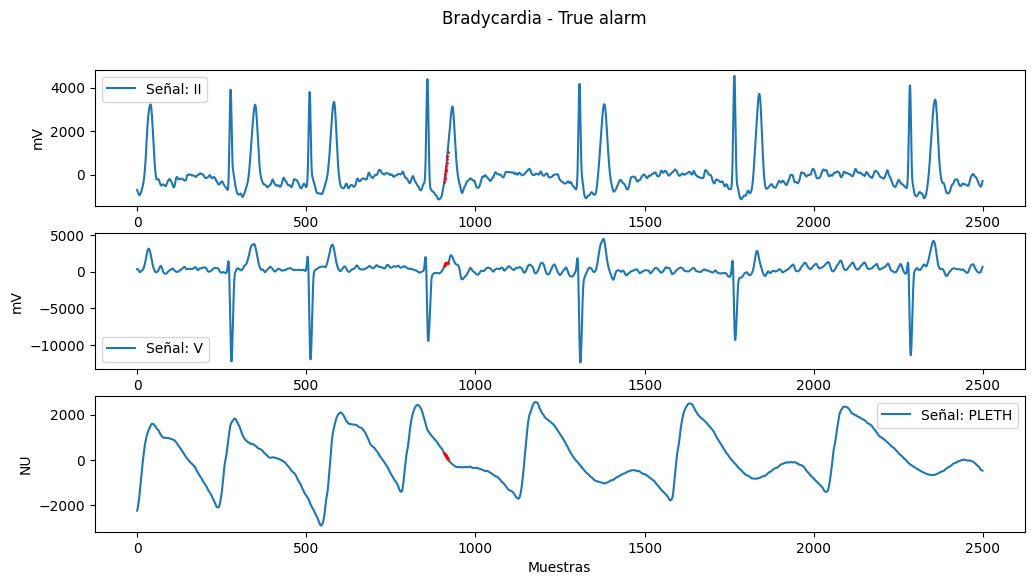

Graficando señales de:  b183l
Picos R señal II: [[1772 1773 1774 1775 1776 1777 1778 1779 1783 1784 2349]]
Picos R señal V: [[1772 1773 1774 1775 1776 1777 1778 1779 1783 1784 2349]]
Picos R señal PLETH: [[1772 1773 1774 1775 1776 1777 1778 1779 1783 1784 2349]]


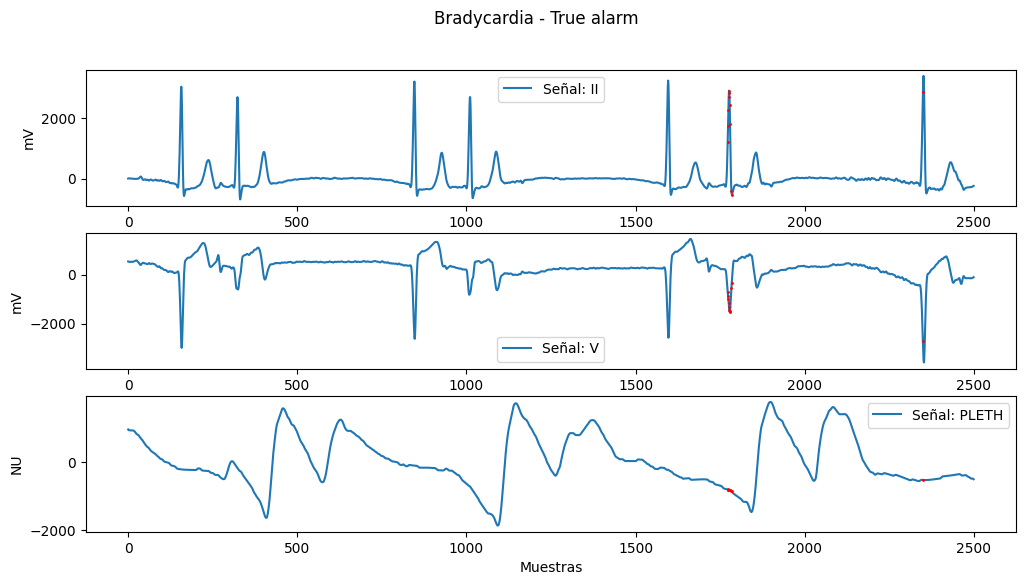

Graficando señales de:  b184s
Picos R señal II: [[ 250  251  252  253  254  255  256  257  258  259  260  508  509  510
   511  512  513  514  515  516  517  518  519  990  991  992  993  994
   995  996  997  998  999 1000 1001 1002 1003 1004 1698 1699 1700 1701
  1702 1703 1704 1705 1706 1707 1708 1709 1710 2431 2432 2433 2434]]
Picos R señal V: [[ 250  251  252  253  254  255  256  257  258  259  260  508  509  510
   511  512  513  514  515  516  517  518  519  990  991  992  993  994
   995  996  997  998  999 1000 1001 1002 1003 1004 1698 1699 1700 1701
  1702 1703 1704 1705 1706 1707 1708 1709 1710 2431 2432 2433 2434]]
Picos R señal PLETH: [[ 250  251  252  253  254  255  256  257  258  259  260  508  509  510
   511  512  513  514  515  516  517  518  519  990  991  992  993  994
   995  996  997  998  999 1000 1001 1002 1003 1004 1698 1699 1700 1701
  1702 1703 1704 1705 1706 1707 1708 1709 1710 2431 2432 2433 2434]]


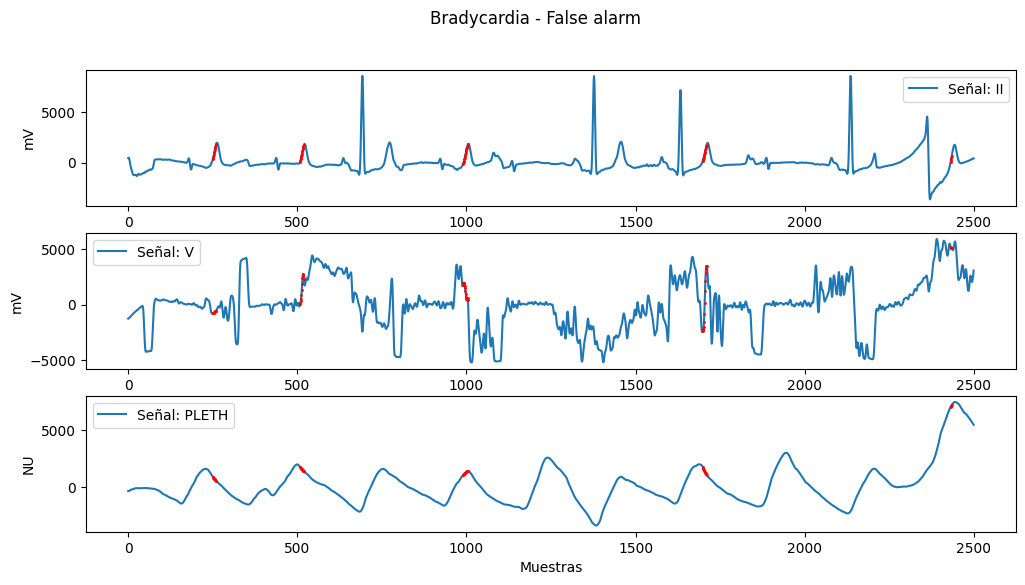

Graficando señales de:  b187l
Picos R señal II: [[  80   84  206  208  425  426  427  428  429  430  431  432  433 1071
  1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1364
  1365 1366 1957 1958 1960 1961 1962 2295 2296 2297 2298 2299 2300 2301
  2302 2303 2304 2305 2306]]
Picos R señal V: [[  80   84  206  208  425  426  427  428  429  430  431  432  433 1071
  1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1364
  1365 1366 1957 1958 1960 1961 1962 2295 2296 2297 2298 2299 2300 2301
  2302 2303 2304 2305 2306]]
Picos R señal PLETH: [[  80   84  206  208  425  426  427  428  429  430  431  432  433 1071
  1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1364
  1365 1366 1957 1958 1960 1961 1962 2295 2296 2297 2298 2299 2300 2301
  2302 2303 2304 2305 2306]]
Picos R señal RESP: [[  80   84  206  208  425  426  427  428  429  430  431  432  433 1071
  1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1364
  1365 1366 195

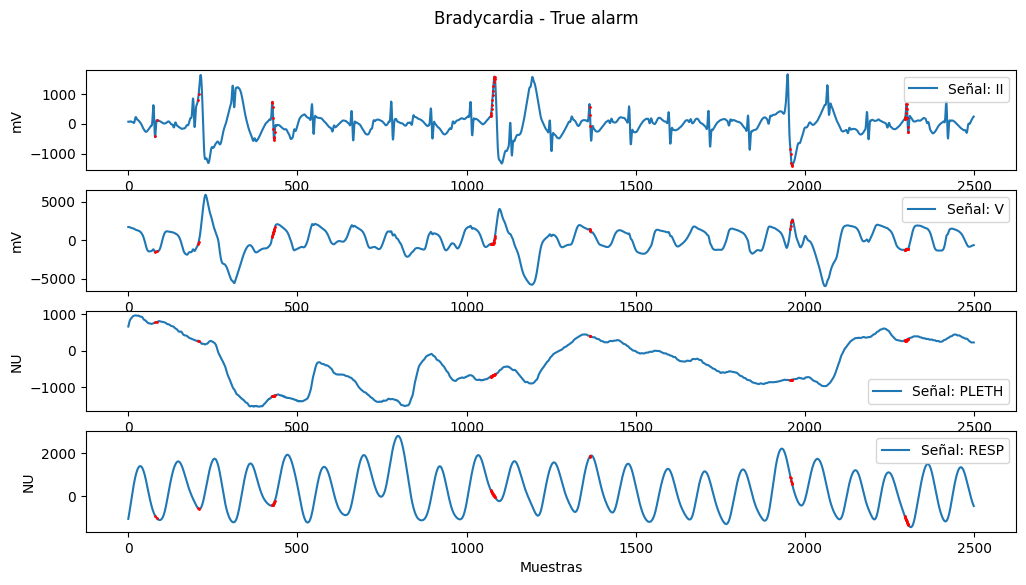

Graficando señales de:  b215l
Picos R señal II: [[  39   63   64   65  537  538  539  540  541  542  543  544  545  546
   685  687  688  695  696  697  698  699  701  839  841  842  844  845
   855  856  857  858  859  860  861  862  863  864  997  998 1019 1175
  1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1339 1343 1344
  1345 1346 1658 1659 1661 1664 1798 1800 1808 1925 1926 1927 1974 1976
  1977 1978 1979 1980 1981 1983 1984 2125 2126 2127 2128 2129 2135 2136
  2137 2138 2282 2283 2302 2304 2305 2308 2309 2310 2445 2452 2453]]
Picos R señal V: [[  39   63   64   65  537  538  539  540  541  542  543  544  545  546
   685  687  688  695  696  697  698  699  701  839  841  842  844  845
   855  856  857  858  859  860  861  862  863  864  997  998 1019 1175
  1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1339 1343 1344
  1345 1346 1658 1659 1661 1664 1798 1800 1808 1925 1926 1927 1974 1976
  1977 1978 1979 1980 1981 1983 1984 2125 2126 2127 2128 2129 2135 2136
  

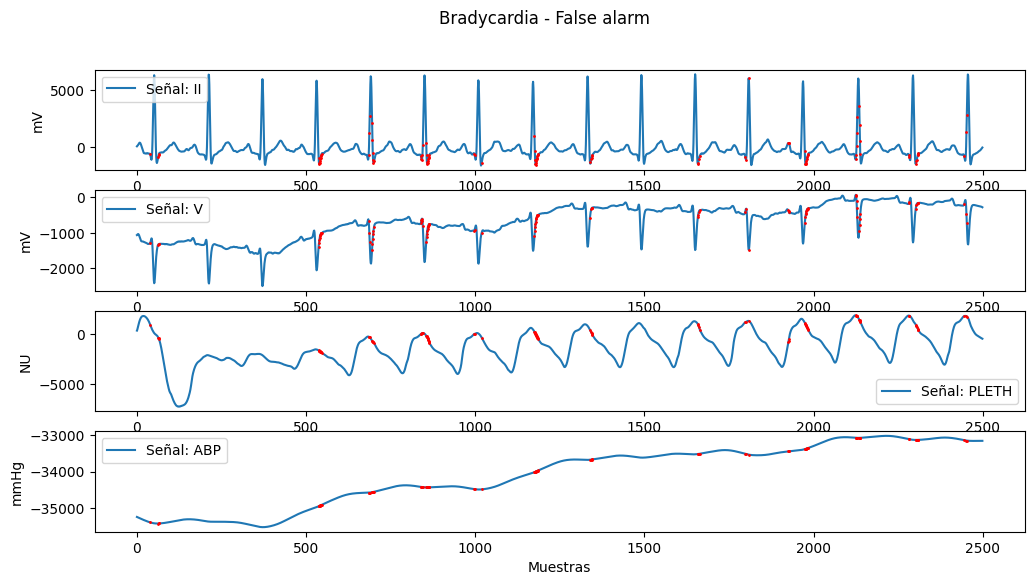

Graficando señales de:  b216s
Picos R señal II: [[ 735  736  737  738  739  740  741  742  743  744  745  746  933  934
   935  936  937  938  939  940  941 1122 1123 1124 1125 1126 1127 1128
  1129 1130 1131 1132 1133 1134 1135 1136 1240 1241 1242 1243 1244 1245
  1246 1247 1248 1249 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333
  1334 1335 1336 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451
  1723 1724 1725 1726 1727 1728 1729 1730 1731 2111 2112]]
Picos R señal V: [[ 735  736  737  738  739  740  741  742  743  744  745  746  933  934
   935  936  937  938  939  940  941 1122 1123 1124 1125 1126 1127 1128
  1129 1130 1131 1132 1133 1134 1135 1136 1240 1241 1242 1243 1244 1245
  1246 1247 1248 1249 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333
  1334 1335 1336 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451
  1723 1724 1725 1726 1727 1728 1729 1730 1731 2111 2112]]
Picos R señal PLETH: [[ 735  736  737  738  739  740  741  742  743  744  745  746  933  934
   9

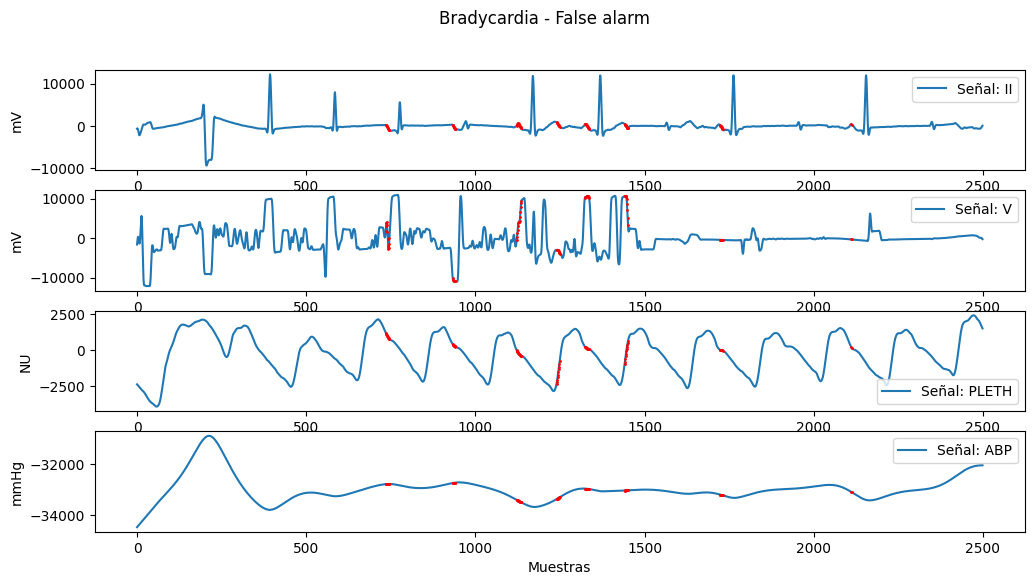

Graficando señales de:  b220s
Picos R señal II: [[ 309  310  311  312  313  314  315  316  317  318  319  320  321  936
   937  938  939  940  941  942  943  944  945  946  947  948  949 1885
  1886 1887 1888 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
  1978 1979]]
Picos R señal V: [[ 309  310  311  312  313  314  315  316  317  318  319  320  321  936
   937  938  939  940  941  942  943  944  945  946  947  948  949 1885
  1886 1887 1888 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
  1978 1979]]
Picos R señal PLETH: [[ 309  310  311  312  313  314  315  316  317  318  319  320  321  936
   937  938  939  940  941  942  943  944  945  946  947  948  949 1885
  1886 1887 1888 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
  1978 1979]]
Picos R señal RESP: [[ 309  310  311  312  313  314  315  316  317  318  319  320  321  936
   937  938  939  940  941  942  943  944  945  946  947  948  949 1885
  1886 1887 1888 1967 1968 1969 1970 1971 1972 1973 1974 197

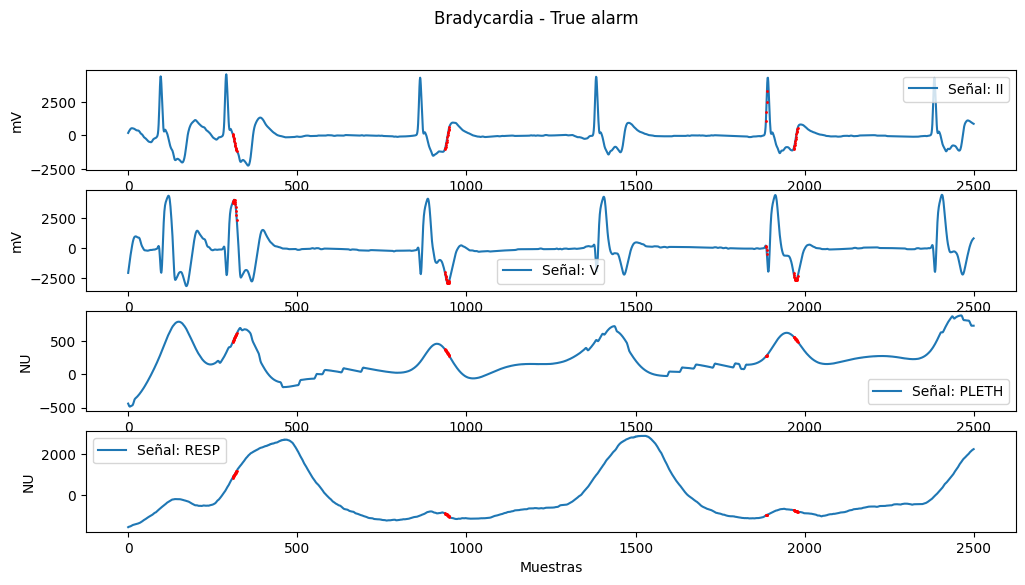

Graficando señales de:  b227l
Picos R señal II: [[  98  138  139  140  142  143  460  462  463  466  467  468  470  471
   472  473  474  475  496  757  868  869  870  871  872 1228 1230 1231
  1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245
  1246 1247 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497
  1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1746 1747 1748
  1749 1750 1751 1752 1753 1754 1755 1756 1757 1790 2110 2111 2112 2113
  2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2144 2146
  2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160
  2161 2162 2165]]
Picos R señal V: [[  98  138  139  140  142  143  460  462  463  466  467  468  470  471
   472  473  474  475  496  757  868  869  870  871  872 1228 1230 1231
  1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245
  1246 1247 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497
  1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 

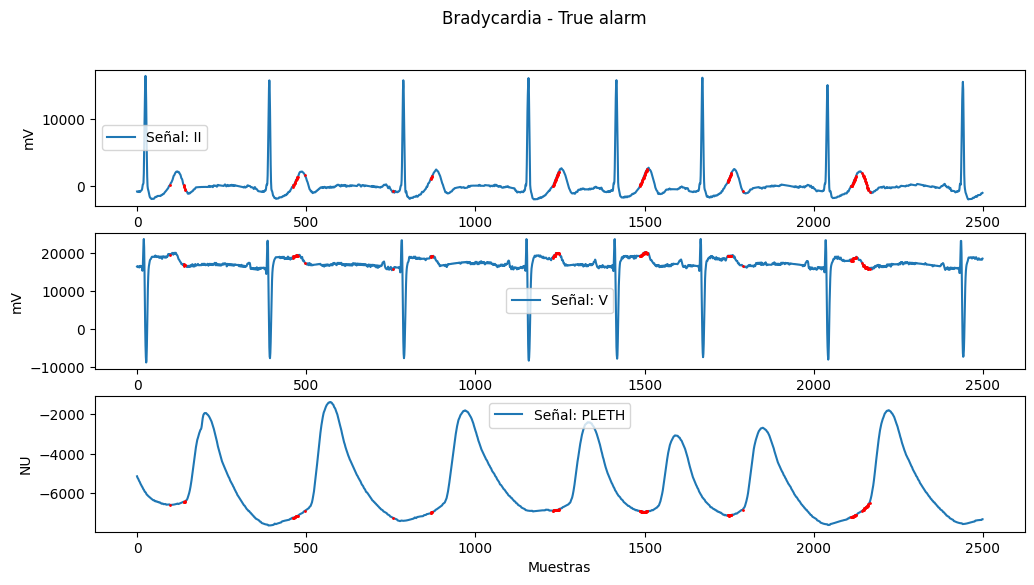

Graficando señales de:  b228s
Picos R señal II: [[ 263  264  265  266  267  268  269  270  271  272  273  530 1261 1262
  1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276
  1277 1278 1623 1624 1625 1626 1627 1628 2013 2014]]
Picos R señal V: [[ 263  264  265  266  267  268  269  270  271  272  273  530 1261 1262
  1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276
  1277 1278 1623 1624 1625 1626 1627 1628 2013 2014]]
Picos R señal PLETH: [[ 263  264  265  266  267  268  269  270  271  272  273  530 1261 1262
  1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276
  1277 1278 1623 1624 1625 1626 1627 1628 2013 2014]]


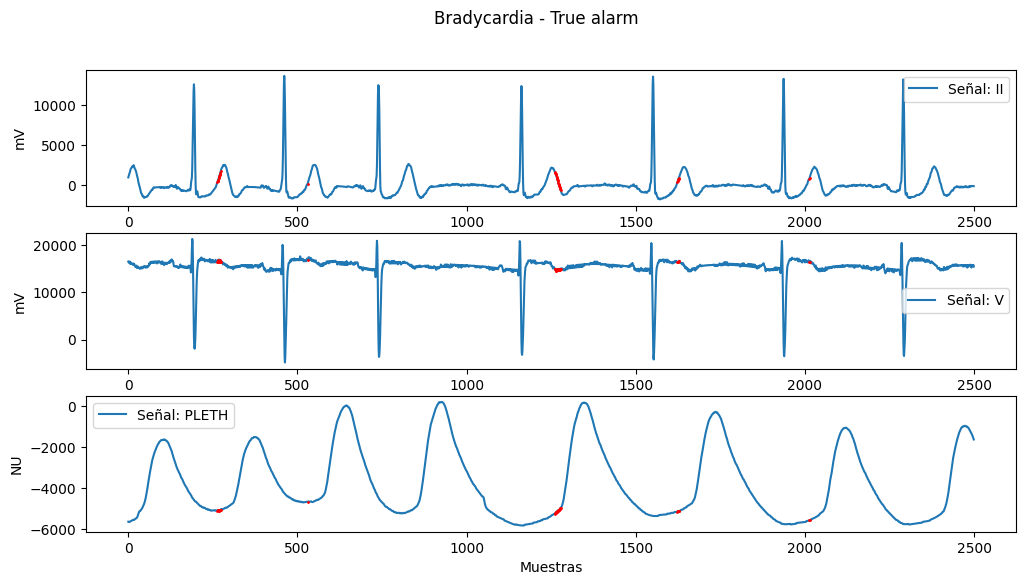

Graficando señales de:  b229l
Picos R señal II: [[ 243  244  245  246  247  248  249  250  251  252  253  431  432  540
   561  562  799  800  801  802  803  804  805  806  807  808  809 1083
  1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1364 1368 1369
  1372 1373 1376 1377 1492 1493 1494 1495 1496 1497 1498 1499 1521 1522
  1527 1528 1529 1530 1531 1532 1533 1534 1535 1538 1539 1540 1892 1894
  1895 1896 1897 1898 1899 1900 1901 1902 1903 2156 2157 2158 2159 2160
  2161 2162 2163 2164 2165 2166 2167 2168 2416 2417 2418 2420 2421 2422
  2423 2424 2425 2426 2427 2428 2429 2435 2441 2442 2443 2444 2445]]
Picos R señal V: [[ 243  244  245  246  247  248  249  250  251  252  253  431  432  540
   561  562  799  800  801  802  803  804  805  806  807  808  809 1083
  1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1364 1368 1369
  1372 1373 1376 1377 1492 1493 1494 1495 1496 1497 1498 1499 1521 1522
  1527 1528 1529 1530 1531 1532 1533 1534 1535 1538 1539 1540 1892 1894
  

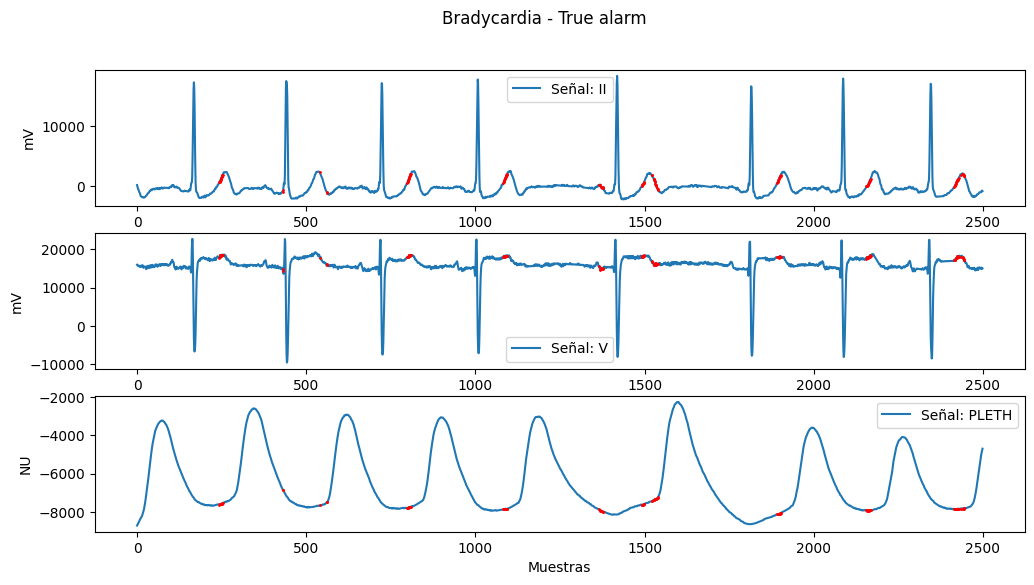

In [15]:
#obteniendo señal limpia y sucia
clean_signals_path = 'data/cleaned/'
dirty_signals_path = 'data/dirty/'


clean_files = get_files(clean_signals_path, '.mat')
dirty_files = get_files(dirty_signals_path, '.mat')

#clasificar tipos de arritmias
comments = []
for file in clean_files:
    record = read_file_hea(file)
    # si encuentra un nuevo comentario lo agrega a la lista
    if record.comments[0] not in comments:
        comments.append(record.comments[0])

print(comments)

#filtrar por arritmia
bradycardia_files_c = []
for file in clean_files:
    record = read_file_hea(file)
    if 'Bradycardia' in record.comments:
        bradycardia_files_c.append(file)
bradycardia_files_d = []
for file in dirty_files:
    record = read_file_hea(file)
    if 'Bradycardia' in record.comments:
        bradycardia_files_d.append(file)

#Asystole_files = []
#for file in clean_files:
#    record = read_file_hea(file)
#    if 'Asystole' in record.comments:
#        bradicardia_files.append(file)


#guardar gráficas
graf_signals(bradycardia_files_c, clean_signals_path, 'clean',12)
#graf_signals(dirty_files, dirty_signal_paths, 'dirty',12)